In [4]:
from IPython.display import Audio
import torch
import os
from scipy.io import wavfile
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader

# Play the .wav file
Audio("digits/0.wav")

In [5]:


class WaveformDataset(Dataset):
    def __init__(self, directory, t_input, max_len, terminal_pad):
        """
        directory: Directory containing the .wav files.
        t_input: Time input array for all files.
        max_len: Maximum length of time steps needed for all files.
        terminal_pad: Number of zeros to pad at the end of each audio file.
        """
        self.directory = directory
        self.files = sorted([f for f in os.listdir(directory) if f.endswith('.wav')], key=lambda x: int(x.split('.')[0]))
        self.t_input = t_input[:max_len]  # Truncate t_input to the maximum required length
        self.terminal_pad = terminal_pad  # Fixed number of zeros to pad
        self.wav_data_list = [self._load_and_pad(os.path.join(directory, f)) for f in self.files]  # Load and pad files
        self.file_indices = []
        self.total_length = 0

        # Calculate lengths of all files and their indices
        for i, wav_data in enumerate(self.wav_data_list):
            length = wav_data.size(1)  # Assuming data is [channels, time], we take the time dimension
            self.file_indices.extend([(i, j) for j in range(length)])
            self.total_length += length

    def _load_and_pad(self, file_path):
        """
        Helper function to load, normalize, and pad the audio file.
        """
        sample_rate, data = wavfile.read(file_path)
        data = torch.tensor(data).unsqueeze(0)  # Convert to tensor and add channel dimension

        # Normalize the data to the range [-1, 1] based on int16
        if data.dtype == torch.int16:
            data = data / 32768.0  # Normalize int16 data
        elif data.dtype == torch.int32:
            data = data / 2147483648.0  # Normalize int32 data
        elif data.dtype == torch.float32:
            pass  # If it's already float, assume it's in [-1, 1]

        # Pad the data with zeros at the end
        pad_length = self.terminal_pad
        data_padded = torch.nn.functional.pad(data, (0, pad_length), mode='constant', value=0)
        #print(data_padded.shape, "data padded")
        return data_padded

    def _generate_target(self, wav_data):
        """
        Helper function to generate the target tensor.
        The target will have 1 in all positions except for the final terminal_pad zeros.
        """
        target = torch.ones_like(wav_data)  # Create a target tensor with all ones
        # Set the last terminal_pad positions to zero
        target[:, -self.terminal_pad:] = 0
        #print(target.shape, "target shape")
        return target

    def __len__(self):
        return self.total_length

    def __getitem__(self, idx):
        file_idx, local_idx = self.file_indices[idx]
        wav_data = self.wav_data_list[file_idx][:, local_idx]  # Slice based on channel and index
        t_step = self.t_input[local_idx]
        target = self._generate_target(self.wav_data_list[file_idx])[:, local_idx]  # Generate the target tensor
        return wav_data, t_step, target, file_idx


In [6]:
class RandomConsecutiveSampler(Sampler):
    def __init__(self, data_source, batch_size, consecutive_size):
        """
        data_source: Dataset that returns (wav_data, time_step, file_idx)
        batch_size: Number of consecutive segments in each batch
        consecutive_size: How many consecutive steps to take for each sampled segment
        """
        self.data_source = data_source
        self.batch_size = batch_size
        self.consecutive_size = consecutive_size

    def __iter__(self):
        indices = np.random.permutation(len(self.data_source) - self.consecutive_size + 1)
        for i in range(0, len(indices), self.batch_size):
            batch_indices = []
            for j in range(i, min(i + self.batch_size, len(indices))):
                start_idx = indices[j]
                batch_indices.extend(range(start_idx, start_idx + self.consecutive_size))
            yield batch_indices

    def __len__(self):
        return (len(self.data_source) - self.consecutive_size ) // self.batch_size


In [7]:
class ConsecutiveDifferenceHigherOrderLossBatch(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLossBatch, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[ 1:, :]
        pred_b = pred_reshape[:-1,:]
        target_a = target_reshape[ 1:, :]
        target_b = target_reshape[:-1,:]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[ 1:, :]
            pred_b = pred_dif[:-1,:]
            target_a = target_dif[ 1:, :]
            target_b = target_dif[:-1,:]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result
    
class ConsecutiveDifferenceHigherOrderLoss(nn.Module):
    def __init__(self, consecutive_size,order=1):
        super(ConsecutiveDifferenceHigherOrderLoss, self).__init__()
        self.consecutive_size = consecutive_size
        self.order = order
    def forward(self, prediction, target):
        pred_reshape = prediction.view(-1, self.consecutive_size)
        target_reshape = target.view(-1, self.consecutive_size)
        result = torch.tensor([0.0])
        
        pred_a = pred_reshape[:, 1:]
        pred_b = pred_reshape[:, :-1]
        target_a = target_reshape[:, 1:]
        target_b = target_reshape[:, :-1]
        for i in range(self.order):
            
            pred_dif = pred_a - pred_b
            target_dif = target_a - target_b
            pred_a = pred_dif[:, 1:]
            pred_b = pred_dif[:, :-1]
            target_a = target_dif[:, 1:]
            target_b = target_dif[:, :-1]
            
            result +=  torch.mean((pred_dif - target_dif) ** 2)/self.order
        return result



In [8]:
directory = "digits/"

In [18]:
import os
from scipy.io import wavfile
import torch
def get_max_required_length(dir):
    max_length = 0
    
    # Iterate over all files in the directory
    for filename in os.listdir(dir):
        if filename.endswith('.wav'):  # Only process .wav files
            file_path = os.path.join(dir, filename)
            
            # Read the .wav file
            sample_rate, data = wavfile.read(file_path)
            
            # Get the length of the audio file (number of samples)
            file_length = data.shape[0]  # shape[0] gives the number of samples (time dimension)
            
            # Update the max length if this file is longer
            if file_length > max_length:
                max_length = file_length

    return max_length

#import torch
#import torch.nn as nn
#import torch.optim as optim



def binary_sequence_tensor(num_bits, length):
    # Create a tensor of shape (length,) with values from 0 to length - 1
    t_values = torch.arange(1,length+1) #start with 1

    # Create a tensor to store the binary representations
    binary_tensor = ((t_values.unsqueeze(1) >> torch.arange(num_bits)) & 1).float()
    binary_tensor[binary_tensor == 0] = -1
    return binary_tensor

In [36]:
target_pad = 20
bits = 16

max_len = get_max_required_length(directory)

t_input = binary_sequence_tensor(bits, max_len+ target_pad)  # Example, adjust this to match your real t_input



#this is for validating
#t_input = np.linspace(1,max_len + target_pad,max_len + target_pad)

# Instantiate the dataset
dataset = WaveformDataset(directory, t_input, max_len, target_pad)

# Sampler setup as before
batch_size = 10
consecutive_size = 10
sampler = RandomConsecutiveSampler(dataset, batch_size, consecutive_size)

# DataLoader
dataloader = DataLoader(dataset, batch_sampler=sampler)

# Example iteration through dataloader
for batch in dataloader:
    wav_data, t_step, target, file_idx = batch #right now this wraps arround, just fyi.  not sure its a bad thing.

    if sum(target)%10 != 0:
        print("Waveform data:", wav_data)
        print("Time step:", t_step)
        print("Target tensor:", target)
        print("File index:", file_idx.shape)
        break

Waveform data: tensor([[ 3.5010e-01],
        [ 3.4512e-01],
        [ 3.5226e-01],
        [ 3.3551e-01],
        [ 3.1650e-01],
        [ 2.7676e-01],
        [ 2.2125e-01],
        [ 1.9659e-01],
        [ 1.7462e-01],
        [ 1.5451e-01],
        [-6.4209e-02],
        [-4.1077e-02],
        [-1.6174e-02],
        [ 1.7120e-02],
        [ 4.8309e-02],
        [ 8.8135e-02],
        [ 1.2817e-01],
        [ 1.6095e-01],
        [ 1.9336e-01],
        [ 2.1521e-01],
        [ 2.7466e-04],
        [ 2.4414e-04],
        [ 2.7466e-04],
        [ 3.3569e-04],
        [ 3.9673e-04],
        [ 3.3569e-04],
        [ 3.9673e-04],
        [ 3.6621e-04],
        [ 3.9673e-04],
        [ 3.3569e-04],
        [ 1.6211e-01],
        [ 1.6522e-01],
        [ 1.6483e-01],
        [ 1.5701e-01],
        [ 1.3593e-01],
        [ 1.0709e-01],
        [ 8.0078e-02],
        [ 6.0944e-02],
        [ 3.1128e-02],
        [ 3.9368e-03],
        [-7.2021e-03],
        [-7.2327e-03],
        [-1.3977e-0

In [11]:
import torch
import torch.nn as nn

class DigitEmbeddingModel(nn.Module):
    def __init__(self, num_digits, embedding_dim, bits, hidden_dim, num_layers):
        super(DigitEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_digits, embedding_dim)
        input_dim = bits + embedding_dim
        
        # Create a list of layers
        layers = []
        for i in range(num_layers):
            in_features = input_dim if i == 0 else hidden_dim
            out_features = hidden_dim
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())  # Add ReLU activation after each linear layer
        
        # Use nn.Sequential to stack the layers
        self.hidden_layers = nn.Sequential(*layers)
        
        # Output layers for binary cross-entropy and MSE
        self.bce_output = nn.Linear(hidden_dim, 1)  # For binary cross-entropy (single scalar)
        self.mse_output = nn.Linear(hidden_dim, 1)  # For mean squared error (single scalar)
        
    def forward(self, digit_index, bits_tensor):
        # Embed the digit_index
        embedded_digit = self.embedding(digit_index)  # Output: [batch_size, embedding_dim]
        
        # Concatenate the embedded digit with the bits_tensor
        concatenated = torch.cat((embedded_digit, bits_tensor), dim=1)  # Output: [batch_size, bits + embedding_dim]
        
        # Pass through the dynamically created hidden layers
        hidden_out = self.hidden_layers(concatenated)
        
        # Compute both outputs
        bce_out = torch.sigmoid(self.bce_output(hidden_out))  # Binary classification output
        mse_out = self.mse_output(hidden_out)  # Regression output
        
        return bce_out, mse_out

# Example usage:
num_digits = 10
embedding_dim = 32
bits = 8
hidden_dim = 64
num_layers = 3

# Instantiate the model
model = DigitEmbeddingModel(num_digits, embedding_dim, bits, hidden_dim, num_layers)

# Example inputs
batch_size = 4
digit_index = torch.randint(0, num_digits, (batch_size,))  # Random digit indices for the batch
bits_tensor = torch.randn(batch_size, bits)  # Random bits tensor

# Forward pass
bce_out, mse_out = model(digit_index, bits_tensor)
print(bce_out.shape)  # Output: [batch_size, 1]
print(mse_out.shape)  # Output: [batch_size, 1]


torch.Size([4, 1])
torch.Size([4, 1])


In [100]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Example usage:
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")
model

Total trainable parameters: 1093762


DigitEmbeddingModel(
  (embedding): Embedding(10, 64)
  (hidden_layers): Sequential(
    (0): Linear(in_features=80, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=512, bias=True)
    (9): ReLU()
  )
  (bce_output): Linear(in_features=512, out_features=1, bias=True)
  (mse_output): Linear(in_features=512, out_features=1, bias=True)
)

In [99]:


# Hyperparameters
hyperparams = {
    "num_digits": 10,        # Number of possible digits
    "embedding_dim": 64,      # Size of the embedding space
    "bits": 16,               # Number of bits in the input tensor
    "hidden_dim": 512,        # Number of units in the hidden layers
    "num_layers": 5,         # Number of hidden layers
    "batch_size": 100,        # Batch size
    "consecutive_size": 20,   
    "terminal_pad": 50      # Amount of padding for each audio file
}

# Instantiate the model
model = DigitEmbeddingModel(
    num_digits=hyperparams['num_digits'], 
    embedding_dim=hyperparams['embedding_dim'], 
    bits=hyperparams['bits'], 
    hidden_dim=hyperparams['hidden_dim'], 
    num_layers=hyperparams['num_layers']
)

##add more layers onto the embedding before t? res blocks? 

In [162]:
# Optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=0.001)
mse_loss_fn = nn.MSELoss()
bce_loss_fn = nn.BCELoss()
cdifb_loss = ConsecutiveDifferenceHigherOrderLossBatch(hyperparams['consecutive_size'],order=3)
cdif_loss = ConsecutiveDifferenceHigherOrderLoss(hyperparams['consecutive_size'],order=3)

# Dataset and DataLoader setup (using the dataset and sampler we worked on)
directory = "digits/" # Replace with your actual directory path

terminal_pad = hyperparams['terminal_pad']
max_len = get_max_required_length(directory) + terminal_pad
t_input = binary_sequence_tensor( hyperparams['bits'], max_len)



# Instantiate the dataset and sampler
dataset = WaveformDataset(directory, t_input, max_len + terminal_pad, terminal_pad)
sampler = RandomConsecutiveSampler(dataset, hyperparams['batch_size'], consecutive_size=hyperparams['consecutive_size'])
dataloader = DataLoader(dataset, batch_sampler=sampler)

num_epochs = 5

# Training loop
for epoch in range(num_epochs):
    model.train()
    
    for batch in dataloader:
        wav_data, t_step, target, file_idx = batch
        
        bce_output, mse_output = model(file_idx, t_step)
        
        # Compute losses
        mse_loss = mse_loss_fn(mse_output*target, wav_data)  # Assuming the target is for MSE
        bce_loss = bce_loss_fn(bce_output, target)  # Assuming the target is for BCE
        cdif = cdif_loss(mse_output*target, wav_data)
        #bc = bc_loss(outputs, targets)
        cdif_b = cdifb_loss(mse_output*target, wav_data)
        
        
        # Combine losses (you can weight them if needed)
        total_loss = mse_loss + 0.1*bce_loss + 1.6*cdif + 0.4*cdif_b
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    # Print progress for each epoch
    print(f"Epoch {epoch+1}/{num_epochs} MSE: {mse_loss.item():.6f} BCE: {bce_loss.item():.6f} CDIF: {cdif.item():.6f} CDIF_B: {cdif_b.item():.6f} Total Loss: {total_loss.item():.8f}")

print("all done sweetheart <3")

Epoch 1/5 MSE: 0.000261 BCE: 0.000006 CDIF: 0.000388 CDIF_B: 0.002422 Total Loss: 0.00185235
Epoch 2/5 MSE: 0.000378 BCE: 0.000005 CDIF: 0.000607 CDIF_B: 0.003345 Total Loss: 0.00268840
Epoch 3/5 MSE: 0.000239 BCE: 0.000005 CDIF: 0.000290 CDIF_B: 0.001974 Total Loss: 0.00149411
Epoch 4/5 MSE: 0.000302 BCE: 0.000005 CDIF: 0.000379 CDIF_B: 0.003002 Total Loss: 0.00210951
Epoch 5/5 MSE: 0.000196 BCE: 0.000004 CDIF: 0.000324 CDIF_B: 0.002022 Total Loss: 0.00152320
all done sweetheart <3


In [163]:
import scipy.io.wavfile as wavfile
file_path = 'digits/2.wav'
sample_rate, file_data = wavfile.read(file_path)


In [171]:
file_num = 7
file_idx = (torch.ones((t_input.shape[0])) * file_num).to(int)

t_step = t_input

all_bce_outputs = []
all_mse_outputs = []

batch_size = 20
# Loop through batches without shuffling
for i in range(0, len(file_idx), batch_size):
    batch_file_idx = file_idx[i:i+batch_size]
    batch_t_step = t_step[i:i+batch_size]
    
    # Pass the batch through the model
    with torch.no_grad():
        bce_output, mse_output = model(batch_file_idx, batch_t_step)
        
    # Append outputs to the lists
    all_bce_outputs.append(bce_output)
    all_mse_outputs.append(mse_output)
    
    print(f"Processed batch {i // batch_size + 1}")

# Concatenate all batches into final tensors
final_bce_output = torch.cat(all_bce_outputs, dim=0)
final_mse_output = torch.cat(all_mse_outputs, dim=0)

# Now you have the complete outputs for all batches
print("Final BCE output shape:", final_bce_output.shape)
print("Final MSE output shape:", final_mse_output.shape)


Processed batch 1
Processed batch 2
Processed batch 3
Processed batch 4
Processed batch 5
Processed batch 6
Processed batch 7
Processed batch 8
Processed batch 9
Processed batch 10
Processed batch 11
Processed batch 12
Processed batch 13
Processed batch 14
Processed batch 15
Processed batch 16
Processed batch 17
Processed batch 18
Processed batch 19
Processed batch 20
Processed batch 21
Processed batch 22
Processed batch 23
Processed batch 24
Processed batch 25
Processed batch 26
Processed batch 27
Processed batch 28
Processed batch 29
Processed batch 30
Processed batch 31
Processed batch 32
Processed batch 33
Processed batch 34
Processed batch 35
Processed batch 36
Processed batch 37
Processed batch 38
Processed batch 39
Processed batch 40
Processed batch 41
Processed batch 42
Processed batch 43
Processed batch 44
Processed batch 45
Processed batch 46
Processed batch 47
Processed batch 48
Processed batch 49
Processed batch 50
Processed batch 51
Processed batch 52
Processed batch 53
Pr

Processed batch 421
Processed batch 422
Processed batch 423
Processed batch 424
Processed batch 425
Processed batch 426
Processed batch 427
Processed batch 428
Processed batch 429
Processed batch 430
Processed batch 431
Processed batch 432
Processed batch 433
Processed batch 434
Processed batch 435
Processed batch 436
Processed batch 437
Processed batch 438
Processed batch 439
Processed batch 440
Processed batch 441
Processed batch 442
Processed batch 443
Processed batch 444
Processed batch 445
Processed batch 446
Processed batch 447
Processed batch 448
Processed batch 449
Processed batch 450
Processed batch 451
Processed batch 452
Processed batch 453
Processed batch 454
Processed batch 455
Processed batch 456
Processed batch 457
Processed batch 458
Processed batch 459
Processed batch 460
Processed batch 461
Processed batch 462
Processed batch 463
Processed batch 464
Processed batch 465
Processed batch 466
Processed batch 467
Processed batch 468
Processed batch 469
Processed batch 470


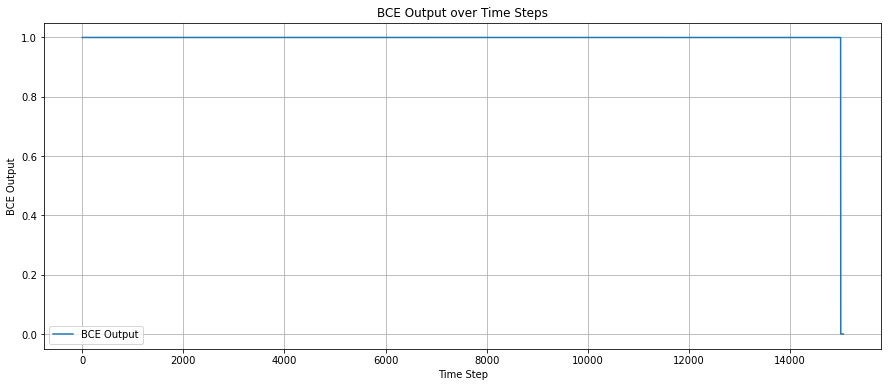

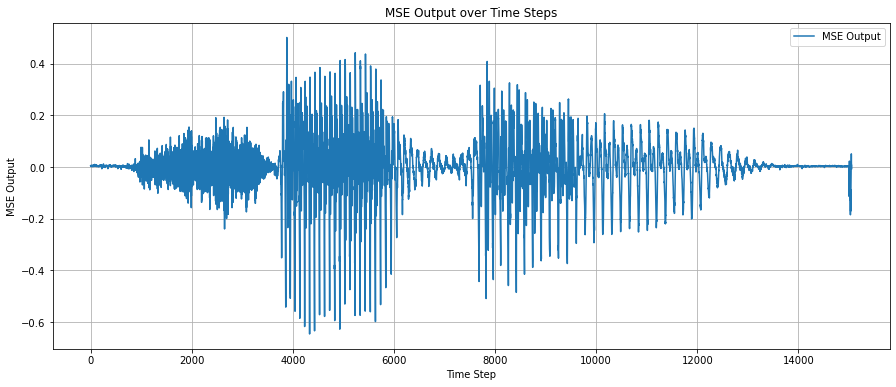

In [172]:
import torch
import matplotlib.pyplot as plt

# Assuming final_bce_output and final_mse_output are already computed
# and have been concatenated from batches

# Example plotting code for final_bce_output and final_mse_output

# Plot BCE Output
plt.figure(figsize=(15, 6))
plt.plot(final_bce_output.numpy(), label="BCE Output")
plt.title("BCE Output over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("BCE Output")
plt.legend()
plt.grid(True)
plt.show()

# Plot MSE Output
plt.figure(figsize=(15, 6))

plt.plot(final_mse_output.numpy(), label="MSE Output")

plt.title("MSE Output over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("MSE Output")
plt.legend()
plt.grid(True)
plt.show()


In [173]:
# Assuming final_bce_output is a 1D tensor with the accumulated BCE outputs

# Find the index of the first value below 0.5
below_threshold_indices = (final_bce_output < 0.5).nonzero(as_tuple=True)[0]
first_below_threshold_idx = 0
if len(below_threshold_indices) > 0:
    first_below_threshold_idx = below_threshold_indices[0].item()  # Get the first index
    print(f"The first instance where BCE output is below 0.5 is at index {first_below_threshold_idx}")
else:
    print("No value below 0.5 was found in the BCE output.")


The first instance where BCE output is below 0.5 is at index 15000


In [174]:
first_below_threshold_idx

15000

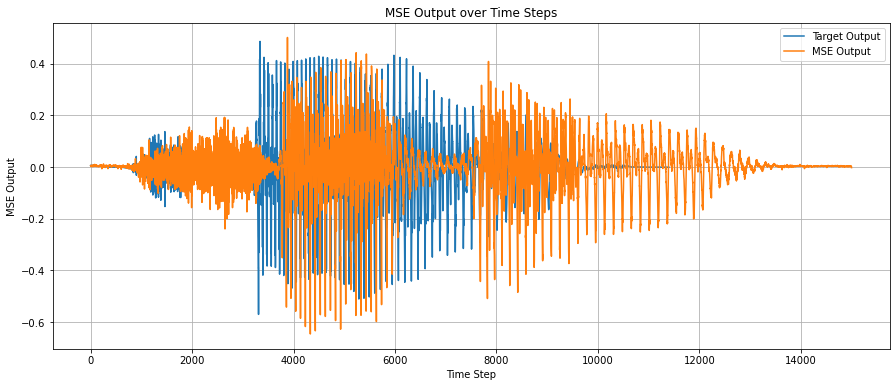

In [175]:
# Plot MSE Output
plt.figure(figsize=(15, 6))
plt.plot(file_data/32768, label="Target Output")
plt.plot(final_mse_output.numpy()[:first_below_threshold_idx], label="MSE Output")

plt.title("MSE Output over Time Steps")
plt.xlabel("Time Step")
plt.ylabel("MSE Output")
plt.legend()
plt.grid(True)
plt.show()


In [176]:
import torch
import numpy as np
from scipy.io.wavfile import write


def tensor_to_wav(tensor, filename, sample_rate=44100,cut_off=-1 ):
    # Convert tensor to numpy array and detach if needed
    data = tensor.detach().cpu().numpy()[:cut_off]
    # Normalize to the range [-1, 1]
    #data = data / np.max(np.abs(data))

    # Convert to 16-bit PCM format (values between -32768 and 32767)
    data_int16 = np.int16(data * 32768)

    # Write the .wav file
    write(filename, sample_rate, data_int16)
    print(f"Saved as {filename}")

# Example usage with your model predictions (assuming predictions are in range -1 to 1):
# predictions is the output tensor from the model
tensor_to_wav(final_mse_output, "test_2.wav", sample_rate=sample_rate,cut_off = first_below_threshold_idx)

Saved as test_2.wav


In [177]:
from IPython.display import Audio

# Play the .wav file
Audio("test_2.wav")

In [52]:
##torch.save(model, "first_try_digits.pth") #this is the first one!!!!! it is intelligible, even tho it is grainy

In [53]:
#torch.save(model, "first_try_digits_cdif.pth")

In [54]:
#torch.save(model, "two_wide_digits_cdif.pth")

In [55]:
model = torch.load("two_wide_digits_cdif.pth")

# Set the model to evaluation mode (if you're using it for inference)
model.eval()

DigitEmbeddingModel(
  (embedding): Embedding(10, 64)
  (hidden_layers): Sequential(
    (0): Linear(in_features=80, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
  )
  (bce_output): Linear(in_features=512, out_features=1, bias=True)
  (mse_output): Linear(in_features=512, out_features=1, bias=True)
)

In [ ]:
if you have a simple embedding for each digit, what if its more complicated? every digit was a little neural network.

forget about that.  
higher than 16, 256? fundamentally if you are 
limited by categories.  those are the words.  

maybe start with some embeddings.  combined in some way? 

get this un noisy.  

could you use this to classify digits.  
